In [73]:
import pandas as pd
from pprint import pprint
import warnings 
warnings.filterwarnings('ignore')
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
import string
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import keras_tuner as kt

In [42]:
data = pd.read_csv('../input/emotion-detection-from-text/tweet_emotions.csv')

print('No. of Tweets: ',data.shape[0])
pprint(all_classes)

data.head()

No. of Tweets:  40000
['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']


,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [44]:
m = data.shape[0]
train_split = 0.80 * m
val_split = (1 - 0.80) * m
test_split = 0.20 * val_split
val_split = (1 - 0.20) * val_split

print('Splitting ratio: ')
print()
print('train_split: ', train_split, ', val_split: ', val_split, ', test-split: ', test_split)

train_data = data.iloc[:int(train_split)]
val_data = data.iloc[int(train_split) + 1: int(train_split) + int(val_split)]
test_data = data.iloc[int(train_split) + int(val_split) + 1 : int(train_split) + int(val_split) + int(test_split)]
print()
print('All_Shapes: ')
print()
print(train_data.shape, val_data.shape, test_data.shape)

del val_split
del train_split
del test_split
gc.collect()

Splitting ratio: 

train_split:  32000.0 , val_split:  6399.999999999999 , test-split:  1599.9999999999998

All_Shapes: 

(32000, 3) (6398, 3) (1598, 3)


23

In [46]:
print(train_data['sentiment'].value_counts())

worry         7641
neutral       6790
sadness       4886
happiness     3434
love          2388
surprise      1743
fun           1247
hate          1216
relief        1130
empty          699
enthusiasm     567
boredom        161
anger           98
Name: sentiment, dtype: int64


In [47]:
maxx = 3
target_majority = train_data[train_data.sentiment==all_classes[maxx]]


for cl in range(13):
    train_minority = data[data.sentiment==all_classes[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=123)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=maxx:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts() 

anger         6790
relief        6790
boredom       6790
happiness     6790
hate          6790
fun           6790
love          6790
surprise      6790
worry         6790
enthusiasm    6790
sadness       6790
empty         6790
neutral       6790
Name: sentiment, dtype: int64

In [51]:
content_text = train_data.content.tolist()
all_classes = train_data.sentiment.unique().tolist()
content_text = train_data.content.tolist()
ex_char = string.punctuation
ex_char = ex_char.replace('~', '')
c_text = '~~~~~~'.join(content_text)

x = c_text.translate(str.maketrans('', '', ex_char))
c_text = x.split('~~~~~~')

#print('Samples: ',len(c_text))

token_data = tf.keras.preprocessing.text.Tokenizer(num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ')
token_data.fit_on_texts(c_text)
ind_text = token_data.texts_to_sequences(c_text)

print()

print('All_samples: ', len(ind_text))
word_index = token_data.word_index
print('Diff. words: ', len(list(word_index)))



All_samples:  32000
Diff. words:  45300


In [55]:
label_token = tf.keras.preprocessing.text.Tokenizer(num_words=len(all_classes),
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ')
classes = ' '.join(all_classes)
label_token.fit_on_texts([classes])
label_index = label_token.word_index
print('No. of Labels: ',len(list(label_index)))
print()
label_index = {key:value-1 for key, value in label_index.items()}
inv_label_index = {value:key for key, value in label_index.items()}
print()
print(inv_label_index)

No. of Labels:  13


{0: 'empty', 1: 'sadness', 2: 'enthusiasm', 3: 'neutral', 4: 'worry', 5: 'surprise', 6: 'love', 7: 'fun', 8: 'hate', 9: 'happiness', 10: 'boredom', 11: 'relief', 12: 'anger'}


In [56]:
y_train = []
for i in train_data.sentiment:
    y_train.append(label_index.get(i))
y_train = np.array(y_train)
print('Label_shape: ', y_train.shape)
pprint(y_train[:10])

Label_shape:  (32000,)
array([0, 1, 1, 2, 3, 4, 1, 4, 1, 1])


In [57]:
x_train = np.array(ind_text)
max_inp_len = len(x_train[0])
for step, i in enumerate(x_train):
    if len(i) > max_inp_len:
        max_inp_len = len(i)
print('max_input_length: ',max_inp_len)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_inp_len, padding = 'post')
print('x_train_shape: ',x_train.shape, ', y_train_shape: ', y_train.shape)

max_input_length:  33
x_train_shape:  (32000, 33) , y_train_shape:  (32000,)


In [65]:
def val_preprocess(val_data, token_data, label_index):
    
    content_text = val_data.content.tolist()
    all_classes = val_data.sentiment.unique().tolist()

    content_text = val_data.content.tolist()
    ex_char = string.punctuation
    ex_char = ex_char.replace('~', '')
    c_text = '~~~~~~'.join(content_text)

    x = c_text.translate(str.maketrans('', '', ex_char))
    c_text = x.split('~~~~~~')

    print('Val_samples: ',len(c_text))
    ind_text = token_data.texts_to_sequences(c_text)
    x_val = np.array(ind_text)
    print()

    print('All_Val_samples: ', len(ind_text))
    
    y_val = []
    for i in val_data.sentiment:
        y_val.append(label_index.get(i))
    y_val = np.array(y_val)
    print('Label_shape: ', y_val.shape)
    
    return x_val, y_val
    
def test_preprocess(test_data, token_data, label_index):
    
    content_text = test_data.content.tolist()
    all_classes = test_data.sentiment.unique().tolist()

    content_text = test_data.content.tolist()
    ex_char = string.punctuation
    ex_char = ex_char.replace('~', '')
    c_text = '~~~~~~'.join(content_text)

    x = c_text.translate(str.maketrans('', '', ex_char))
    c_text = x.split('~~~~~~')

    print('Again_Test_samples: ',len(c_text))
    ind_text = token_data.texts_to_sequences(c_text)
    x_test = np.array(ind_text)
    print()
    print('All_Test_samples: ', len(ind_text))
    y_test = []
    for i in test_data.sentiment:
        y_test.append(label_index.get(i))
    y_test = np.array(y_test)
    print('Label_shape: ', y_test.shape)
    
    return x_test, y_test
        

print('Val_Preprocessing:')
x_val, y_val = val_preprocess(val_data, token_data, label_index)
#print(x_val.shape, y_val.shape)
print('--------')
print('Test_Preprocessing ...')
x_test, y_test = test_preprocess(test_data, token_data, label_index)
#print(x_test.shape, y_test.shape)


Val_Preprocessing:
Val_samples:  6398

All_Val_samples:  6398
Label_shape:  (6398,)
--------
Test_Preprocessing ...
Again_Test_samples:  1598

All_Test_samples:  1598
Label_shape:  (1598,)


In [66]:
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen = max_inp_len, padding = 'post')
print('x_val_shape: ',x_val.shape, ', y_val_shape: ', y_val.shape)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_inp_len, padding = 'post')
print('x_test_shape: ',x_test.shape, ', y_test_shape: ', y_test.shape)

x_val_shape:  (6398, 33) , y_val_shape:  (6398,)
x_test_shape:  (1598, 33) , y_test_shape:  (1598,)


In [74]:
class T_encoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, embd_dim, dense_dim, num_classes , **kwargs):
        super(T_encoder, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.embd_dim = embd_dim
        self.dense_dim = dense_dim
        self.multi_head_layer = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embd_dim)
        
        self.dense_layer = tf.keras.models.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(embd_dim)])
        
        self.norm_layer_1 = tf.keras.layers.LayerNormalization()
        self.norm_layer_2 = tf.keras.layers.LayerNormalization()
        self.Final_Dense = tf.keras.layers.Dense(num_classes, activation = 'softmax')
        self.supports_mask = True
    

    def call(self, inputs, mask=None): ## we mask the padding in encoder model
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype='int32') ## because attention is 5-D tensor 
        att_output = self.multi_head_layer(query = inputs, value = inputs, key = inputs, attention_mask = padding_mask)# (all vals) after instantiating pass query, value and key
        att_output = tf.keras.layers.Dropout(0.5)(att_output)
        output_1 = self.norm_layer_1(att_output + inputs)
        
        dense_output = self.dense_layer(output_1)
        output_2 = self.norm_layer_2(dense_output + output_1)
        fl_output = tf.keras.layers.Flatten()(output_2)
        encoder_output = self.Final_Dense(fl_output)
        
        return encoder_output
        
class positional_encoding(tf.keras.layers.Layer):
    def __init__(self, inp_dim , max_seq_len, embd_dim, **kwargs):
        super(positional_encoding, self).__init__(**kwargs)
        self.inp_dim = inp_dim
        self.max_seq_len = max_seq_len
        self.embd_dim = embd_dim
        self.embd_layer = tf.keras.layers.Embedding(input_dim = inp_dim, output_dim = embd_dim)
        self.pos_layer = tf.keras.layers.Embedding(input_dim = max_seq_len, output_dim = embd_dim)
        
    def call(self, inputs):
        embd_output_1 = self.embd_layer(inputs)
        pos_in = tf.range(start = 0, limit = self.max_seq_len, delta =1)
        pos_output_1 = self.pos_layer(pos_in)
        model_input = embd_output_1 + pos_output_1
        return model_input
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0) 


In [75]:
def sec(epoch, learning_rate):
    if epoch <= 2:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.9)

lrs = tf.keras.callbacks.LearningRateScheduler(sec)
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

In [79]:
embd_dim = 64
num_heads = 2
dense_dim = 64
num_classes = len(all_classes)

def tuner_model(hp):
    hp_embd_dim = hp.Int('embd_dim', min_value = 16, max_value = 512, step = 16)
    hp_num_heads = hp.Int('num_heads', min_value = 2, max_value = 10, step = 2)
    hp_dense_dim = hp.Int('dense_dim', min_value = 16, max_value = 512, step = 16)
    hp_lr = hp.Choice('lr', values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    
    inp_1  = tf.keras.layers.Input(shape=(x_train.shape[-1], ))
    pos_op = positional_encoding(inp_dim = len(list(word_index))+1, max_seq_len = max_inp_len, embd_dim = hp_embd_dim )(inp_1)
    enc_op = T_encoder(num_heads = hp_num_heads , embd_dim = hp_embd_dim, dense_dim = hp_dense_dim, num_classes = num_classes)(pos_op)

    transformer = tf.keras.models.Model(inputs = inp_1, outputs = enc_op, name = 'Transformer')
    transformer.compile(loss = "sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = hp_lr), metrics = ['accuracy'])
    return transformer

tuner = kt.Hyperband(tuner_model, objective = 'loss', max_epochs = 3)
tuner.search(x_train, y_train, epochs=5, callbacks=[stop_early, lrs])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model_transformer = tuner.hypermodel.build(best_hps)
model_transformer.summary()

#tf.keras.utils.plot_model(model_transformer, show_shapes = True)

Model: "Transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33)]              0         
_________________________________________________________________
positional_encoding (positio (None, 33, 160)           7253440   
_________________________________________________________________
t_encoder (T_encoder)        (None, 13)                763933    
Total params: 8,017,373
Trainable params: 8,017,373
Non-trainable params: 0
_________________________________________________________________


(32000, 33) (32000,)
Epoch 1/25
1000/1000 [==============================] - 100s 99ms/step - loss: 2.2358 - accuracy: 0.2632 - val_loss: 2.0357 - val_accuracy: 0.3284
Epoch 2/25
1000/1000 [==============================] - 98s 98ms/step - loss: 1.4823 - accuracy: 0.5079 - val_loss: 2.3486 - val_accuracy: 0.3131
Epoch 3/25
1000/1000 [==============================] - 102s 102ms/step - loss: 0.4845 - accuracy: 0.8504 - val_loss: 2.7832 - val_accuracy: 0.2902
Epoch 4/25
1000/1000 [==============================] - 104s 104ms/step - loss: 0.1606 - accuracy: 0.9500 - val_loss: 3.1773 - val_accuracy: 0.2890
Epoch 5/25
1000/1000 [==============================] - 99s 99ms/step - loss: 0.0821 - accuracy: 0.9758 - val_loss: 3.4331 - val_accuracy: 0.2834
Epoch 6/25
1000/1000 [==============================] - 99s 99ms/step - loss: 0.0578 - accuracy: 0.9826 - val_loss: 3.7619 - val_accuracy: 0.2902
Epoch 7/25
1000/1000 [==============================] - 100s 100ms/step - loss: 0.0481 - accuracy:

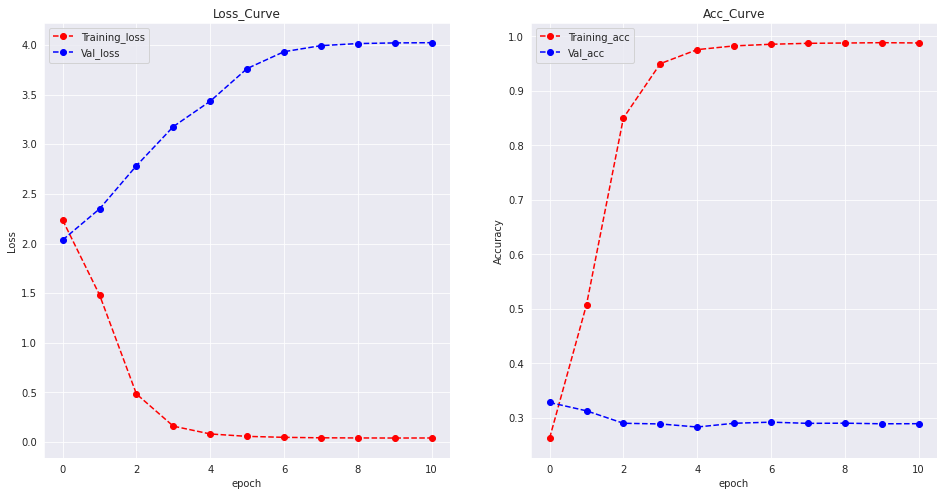

In [80]:
print(x_train.shape, y_train.shape)
his2 = model_transformer.fit(x_train, y_train, epochs=25, validation_data=(x_val, y_val), batch_size=32, callbacks = [stop_early, lrs]) ## Learining_rate_scheduler helps in controlling your loss
print()
print('-- Evaluation --')
model_transformer.evaluate(x_test, y_test)
print()
his_2 = his2.history

fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].set_title('Loss_Curve')
ep = range(len(his_2['loss']))
axs[0].plot(ep, his_2['loss'],'o--r',label = 'Training_loss')
axs[0].plot(ep, his_2['val_loss'],'o--b',label = 'Val_loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Acc_Curve')
ep = range(len(his_2['loss']))
axs[1].plot(ep, his_2['accuracy'],'o--r',label = 'Training_acc')
axs[1].plot(ep, his_2['val_accuracy'],'o--b',label = 'Val_acc')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [81]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

ypred = model_transformer.predict(x_test)
ypred = np.argmax(ypred, axis=-1)
conf_matrix  = confusion_matrix(ypred, y_test)

print('--Confusion_Matrix--')
print()
print(conf_matrix)
print()
print('f1_score: ',f1_score(y_test, ypred, average='micro'))
print('Precsion: ',precision_score(y_test, ypred, average='micro'))
print('Recall: ',recall_score(y_test, ypred, average='micro'))

--Confusion_Matrix--

[[  0   0   2   3   2   1   1   0   1   2   0   1   0]
 [  1  12   4  31  14   9   8   6   8  22   2  11   0]
 [  0   0   1   4   2   1   2   1   1   1   0   0   0]
 [ 12  11  14 162  54  19  37  18   4  70   2  32   0]
 [  7   7   8  63  54  16  28  23   4  48   1  16   0]
 [  1   1   1  10   8   5   5   3   1  11   0   3   0]
 [  0   4   1  29   8  13 118   9   1  59   0   9   0]
 [  1   0   0   9   2   2   7   5   0  10   0   1   0]
 [  0   3   1   0   3   0   0   0   1   1   0   0   0]
 [  3   8   7  50  27  17  63  23   2 126   0  11   1]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  1   5   0   8   5   2   8   2   0  13   0   4   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0]]

f1_score:  0.3053817271589487
Precsion:  0.3053817271589487
Recall:  0.3053817271589487


In [82]:
## inference
import random

index = {}
for val, key in enumerate(word_index.keys()):
    index[val+1] = key 
inv_word_index = index
inv_word_index[0] = ''


def reverser(inp):
    st = ''
    for i in inp:
        st += ' ' + str(inv_word_index.get(i))
    return st

def predict():
    seed = random.randint(0, x_test.shape[0])
    x_seed = x_test[seed]
    act = y_test[seed]
    st = reverser(x_seed)
    print('Input_Sentence: ', st)
    print('--'*20)
    print('Actual_emotion: ', inv_label_index.get(act))
    pred = (np.argmax(model_transformer.predict(x_seed.reshape(1,-1)), axis=-1).tolist())
    print('--'*20)
    print('Predicted_emotion: ', inv_label_index.get(pred[-1]))

for _ in range(5):
    print('-'*50)
    predict()
    print('-'*50)
    print()

--------------------------------------------------
Input_Sentence:   happy mothers day to all moms                           
----------------------------------------
Actual_emotion:  neutral
----------------------------------------
Predicted_emotion:  neutral
--------------------------------------------------

--------------------------------------------------
Input_Sentence:   somehow i cant reply to your message lol and yes i know thank youuu                   
----------------------------------------
Actual_emotion:  happiness
----------------------------------------
Predicted_emotion:  love
--------------------------------------------------

--------------------------------------------------
Input_Sentence:   hi fellow                               
----------------------------------------
Actual_emotion:  neutral
----------------------------------------
Predicted_emotion:  neutral
--------------------------------------------------

------------------------------------------------